# Train without normalize
# Train with datasets: CHARM and MotionSense
# Test with dataset: KuHar

1. Apply DFT over dataset windows and universal UMAP
2. Train three times with RF, SVM and KNN, and take the average accuracy and f1-score
3. Plot UMAP and T-SNE

# Crossvalidation experiments with CHARM and MotionSense as base and KuHar as target

This notebook will perform crossvalidation experiments using the CHARM and MotionSense datasets at 20 Hz as training dataset. It will contain the following steps:

1. Quick load train, test and validation CSV subsets from the balanced KuHar and MotionSense datasets at 20 Hz using `PandasDatasetsIO` helper
2. Quick load train, test and validation CSV subsets from other relevant datasets using `PandasDatasetsIO` helper
3. Subclassing the `Dataset` interface using `PandasMultiModalDataset`
4. Apply the fourier transform on Charm
5. Apply universal UMAP
6. Train SVM, KNN and Random Forest classification models on the CHARM and MotionSense dataset in the frequency domain with dimensionality reduction
7. Evaluate SVM, KNN and Random Forest classification models on KuHar in the frequency domain with dimensionality reduction

The experiments will evaluate the performance of SVM, KNN and RF models trained on a balanced KuHar and MotionSense datasets and tested on Charm in the frequency domain with dimensionality reduction.

In [1]:
from pathlib import Path  # For defining dataset Paths
import sys
sys.path.append("../../../..")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
#from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# Librep imports
from librep.utils.dataset import PandasDatasetsIO          # For quick load train, test and validation CSVs
from librep.datasets.har.loaders import ExtraSensorySenseUnbalancedResampledView20HZ, UCIHARUnbalancedView, WISDMInterpolatedUnbalancedView, KuHarResampledView20HZ, MotionSenseResampledView20HZ, CHARMUnbalancedView

from librep.datasets.multimodal import PandasMultiModalDataset, TransformMultiModalDataset, WindowedTransform
from librep.transforms.fft import FFT
from librep.utils.workflow import SimpleTrainEvalWorkflow, MultiRunWorkflow
from librep.estimators import RandomForestClassifier, SVC, KNeighborsClassifier
from librep.metrics.report import ClassificationReport
from librep.transforms.resampler import SimpleResampler

2022-10-06 20:57:37.463418: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-06 20:57:37.463440: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Datasets to train the manifold

## Load ExtraSensory

In [3]:
# Load ExtraSensory, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = ExtraSensorySenseUnbalancedResampledView20HZ("../../../../data/views/ExtraSensory/unbalanced_20Hz_train-v1", download=False)
train_val_es = loader.load()[0]

In [4]:
train_val_es.data.iloc[:,:-8]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,0.008949,0.008045,0.013382,0.005547,0.009171,0.009484,0.002682,0.012434,0.005247,0.009579,...,-0.001655,-0.000548,-0.000017,0.000043,0.000608,-0.000553,-0.000506,-0.001651,-0.001260,-0.001771
1,0.007885,0.009641,0.007848,0.008434,0.008560,0.010423,0.005289,0.009952,0.006066,0.013453,...,0.000718,0.000260,-0.001939,-0.002040,0.000396,-0.000077,0.000641,0.000218,-0.001614,-0.001665
2,0.004486,0.007144,0.009683,0.009572,0.006842,0.007341,0.008749,0.009397,0.003069,0.007115,...,0.000231,-0.000082,-0.001318,-0.000512,-0.000142,0.000494,-0.000758,-0.000029,-0.000178,-0.000234
3,0.020244,0.002507,0.003476,0.034731,-0.002707,0.001861,0.015341,0.009896,0.011484,0.012472,...,0.000265,-0.001829,0.002546,0.017213,-0.010562,-0.013196,-0.010576,-0.022032,0.000801,0.011156
4,0.106152,0.132884,0.183170,0.291983,0.360944,0.410960,0.518888,0.558418,0.531926,0.401361,...,0.497501,0.807196,1.130580,0.952069,1.002923,0.757847,0.743950,0.508856,0.377331,0.000129
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25013,-1.834111,-0.634135,-1.367796,-1.563685,0.093902,3.411275,3.275478,1.867727,2.115405,1.492043,...,-0.290813,0.719708,0.847638,1.760178,1.281648,1.322466,1.628261,1.570378,0.900619,0.834545
25014,-1.671332,-0.954864,-1.008532,-0.448472,0.462539,-0.801835,0.874602,2.768817,-0.326576,1.012099,...,-0.053546,0.184549,-0.257309,-0.404991,0.124664,0.337072,0.998640,0.856102,0.151099,-0.885227
25015,0.859988,0.631427,0.620590,-0.064888,-0.269615,-0.140573,0.895613,1.237965,2.451095,2.157884,...,-0.320985,-0.161766,1.462780,2.268645,0.064582,0.192397,-2.679766,-3.254175,-2.500430,-2.721948
25016,0.269790,1.437568,-2.278815,6.520354,1.231790,-0.579296,0.234414,-1.820842,-1.080017,-0.593806,...,0.106716,-0.184656,-0.820349,-1.004691,-0.678159,0.374021,0.109051,1.239222,1.313676,-0.372590


In [5]:
train_val_es.data['standard activity code']

0        1
1        1
2        1
3        1
4        1
        ..
25013    2
25014    2
25015    2
25016    2
25017    2
Name: standard activity code, Length: 25018, dtype: int64

In [6]:
extrasensory_X = train_val_es.data.iloc[:,:-8]
extrasensory_Y = train_val_es.data['standard activity code']

tam = len(extrasensory_Y)
extrasensory_id_dataset = np.array(['E']*tam)

## Load UCI-HAR

In [7]:
# Load UCI-HAR, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = UCIHARUnbalancedView("../../../../data/views/UCI-HAR/unbalanced_20Hz_train_test-v1", download=False)
train_val_uci, test_uci = loader.load(concat_train_validation=True)

In [8]:
train_val_uci.data

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,activity code,user,standard activity code
0,0.003565,0.008901,0.005801,0.004948,0.006308,0.005960,0.005928,0.006170,0.007250,0.006326,...,0.000240,-0.000519,-0.001399,0.001455,0.003015,0.010595,0.003470,5,1,1
1,0.001266,-0.001774,0.001172,0.000990,-0.000784,-0.001122,0.002905,0.002715,-0.000973,0.000815,...,-0.000780,-0.005341,-0.009295,-0.011561,-0.009854,-0.003153,0.000108,5,1,1
2,0.000546,-0.000908,-0.001513,-0.001802,0.000595,0.001365,-0.001567,-0.000779,-0.000577,-0.000263,...,-0.000859,0.001881,0.003989,0.002610,0.000582,0.010218,0.021120,5,1,1
3,0.003104,0.001146,-0.004158,0.001729,-0.000769,0.001305,0.003918,-0.002209,-0.000397,-0.001232,...,-0.002719,0.003975,0.001041,-0.004906,0.000427,-0.000771,-0.013023,5,1,1
4,-0.001820,0.000755,0.001618,0.002065,-0.000736,-0.001323,0.002889,-0.001119,0.001074,-0.003958,...,0.002172,0.000114,0.000322,-0.001916,0.001534,0.002732,0.007108,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2454,0.013458,-0.070288,0.069952,0.026208,0.137807,0.375901,0.596737,0.329611,0.043722,-0.056924,...,-0.218047,-0.547776,-0.612564,-0.837015,-0.729588,-0.472352,-0.211776,2,30,3
2455,0.140879,0.144345,0.464152,0.456810,0.267120,-0.026908,-0.131830,-0.147693,-0.364213,-0.355118,...,-0.476739,-0.819931,-0.750365,-0.630116,-0.337958,0.013349,0.153647,2,30,3
2456,0.132817,0.460201,0.530693,0.298639,0.018089,-0.059733,-0.115499,-0.287280,-0.350470,-0.343768,...,0.120246,0.357961,0.001281,-0.054251,0.315337,0.080816,0.326850,2,30,3
2457,-0.111181,-0.336622,-0.329962,-0.202659,-0.255559,-0.228172,-0.063806,0.102427,0.427488,0.676010,...,-0.229515,0.025977,0.066758,0.067897,0.115644,0.092375,0.298367,2,30,3


In [9]:
train_val_uci.data.iloc[:,:-3]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,0.003565,0.008901,0.005801,0.004948,0.006308,0.005960,0.005928,0.006170,0.007250,0.006326,...,-0.002097,-0.001315,0.002887,0.000240,-0.000519,-0.001399,0.001455,0.003015,0.010595,0.003470
1,0.001266,-0.001774,0.001172,0.000990,-0.000784,-0.001122,0.002905,0.002715,-0.000973,0.000815,...,-0.003287,0.002715,0.002455,-0.000780,-0.005341,-0.009295,-0.011561,-0.009854,-0.003153,0.000108
2,0.000546,-0.000908,-0.001513,-0.001802,0.000595,0.001365,-0.001567,-0.000779,-0.000577,-0.000263,...,0.003624,0.005612,0.006521,-0.000859,0.001881,0.003989,0.002610,0.000582,0.010218,0.021120
3,0.003104,0.001146,-0.004158,0.001729,-0.000769,0.001305,0.003918,-0.002209,-0.000397,-0.001232,...,-0.007704,-0.005069,0.005707,-0.002719,0.003975,0.001041,-0.004906,0.000427,-0.000771,-0.013023
4,-0.001820,0.000755,0.001618,0.002065,-0.000736,-0.001323,0.002889,-0.001119,0.001074,-0.003958,...,0.006845,0.005905,0.006080,0.002172,0.000114,0.000322,-0.001916,0.001534,0.002732,0.007108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2454,0.013458,-0.070288,0.069952,0.026208,0.137807,0.375901,0.596737,0.329611,0.043722,-0.056924,...,0.775176,0.479487,0.243283,-0.218047,-0.547776,-0.612564,-0.837015,-0.729588,-0.472352,-0.211776
2455,0.140879,0.144345,0.464152,0.456810,0.267120,-0.026908,-0.131830,-0.147693,-0.364213,-0.355118,...,0.258731,-0.231263,-0.481620,-0.476739,-0.819931,-0.750365,-0.630116,-0.337958,0.013349,0.153647
2456,0.132817,0.460201,0.530693,0.298639,0.018089,-0.059733,-0.115499,-0.287280,-0.350470,-0.343768,...,-0.457300,-0.472327,-0.177299,0.120246,0.357961,0.001281,-0.054251,0.315337,0.080816,0.326850
2457,-0.111181,-0.336622,-0.329962,-0.202659,-0.255559,-0.228172,-0.063806,0.102427,0.427488,0.676010,...,0.098396,0.205140,0.012599,-0.229515,0.025977,0.066758,0.067897,0.115644,0.092375,0.298367


In [10]:
uci_X = train_val_uci.data.iloc[:,:-3]
uci_Y = train_val_uci.data['standard activity code']

tam = len(uci_Y)
uci_id_dataset = np.array(['U']*tam)

## Load WISDM

In [11]:
# Load WISDM and create PandasMultiModalDatasets with the correct pre-defined windows
loader = WISDMInterpolatedUnbalancedView("../../../../data/views/WISDM/unbalanced_20Hz_train_test-v1", download=False)
train_val_wisdm, test_wisdm = loader.load(concat_train_validation=True)
train_val_wisdm.data

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,activity code,user,standard activity code
0,-0.364761,-0.900995,1.988477,0.504245,-2.074267,-4.365631,-0.503460,1.585056,-0.192807,-1.778517,...,0.021654,-0.008257,-0.392786,-0.329143,-0.074698,-0.027220,0.314905,0,1600,2
1,0.081002,-0.059554,0.429260,1.072248,-2.011736,-4.792650,-2.087036,0.663866,0.317017,-1.504834,...,0.345166,0.294343,-0.417068,-0.172208,0.067521,0.406141,0.615971,0,1600,2
2,0.192588,-0.855499,-1.242746,0.316417,-1.833108,-4.946311,1.429507,1.555702,-1.230934,-2.758278,...,0.341863,0.039910,-0.253467,-0.607339,-0.102324,0.100644,0.608968,0,1600,2
3,1.506239,-1.887573,-0.375515,0.282729,-2.745547,-5.598461,-1.923976,1.519264,0.538521,-2.826598,...,0.408067,0.268658,-0.341150,-0.359142,-0.065309,-0.015974,0.365056,0,1600,2
4,-0.494237,-0.791543,0.976555,1.730751,-4.135104,-7.033570,-3.470397,-1.347896,0.434743,0.326745,...,-0.459501,0.421399,-0.182202,-0.406128,-0.590792,-0.174049,0.307581,0,1600,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10818,-0.705972,-0.726914,-0.808348,-0.727646,-0.519297,-0.706294,-0.778460,-0.935760,-0.656630,-0.765051,...,0.015264,0.003391,-0.007575,0.000763,0.015584,-0.014311,-0.016027,4,1635,1
10819,-0.608502,-0.795883,-0.552300,-0.851302,-0.894535,-0.706040,-0.784716,-0.855779,-0.704870,-0.683281,...,-0.003144,-0.002943,0.005729,-0.010290,-0.006023,-0.006458,-0.001189,4,1635,1
10820,-0.777215,-0.714181,-0.765897,-0.765035,-0.697754,-0.852415,-0.749396,-0.637518,-0.757676,-0.702906,...,-0.001254,0.006774,-0.001247,0.001032,0.006439,0.005181,0.011468,4,1635,1
10821,-1.073461,-0.614644,-0.764390,-0.546810,-0.874834,-0.619953,-0.698473,-0.924804,-0.704255,-0.736017,...,0.004119,0.000570,-0.035448,-0.028324,0.004960,0.002800,-0.004581,4,1635,1


In [12]:
train_val_wisdm.data.iloc[:,:-3]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,-0.364761,-0.900995,1.988477,0.504245,-2.074267,-4.365631,-0.503460,1.585056,-0.192807,-1.778517,...,-0.400735,-0.302704,-0.193205,0.021654,-0.008257,-0.392786,-0.329143,-0.074698,-0.027220,0.314905
1,0.081002,-0.059554,0.429260,1.072248,-2.011736,-4.792650,-2.087036,0.663866,0.317017,-1.504834,...,-0.425415,0.143507,-0.229825,0.345166,0.294343,-0.417068,-0.172208,0.067521,0.406141,0.615971
2,0.192588,-0.855499,-1.242746,0.316417,-1.833108,-4.946311,1.429507,1.555702,-1.230934,-2.758278,...,-0.369517,-0.031353,-0.265816,0.341863,0.039910,-0.253467,-0.607339,-0.102324,0.100644,0.608968
3,1.506239,-1.887573,-0.375515,0.282729,-2.745547,-5.598461,-1.923976,1.519264,0.538521,-2.826598,...,-0.667743,-0.639873,-0.394629,0.408067,0.268658,-0.341150,-0.359142,-0.065309,-0.015974,0.365056
4,-0.494237,-0.791543,0.976555,1.730751,-4.135104,-7.033570,-3.470397,-1.347896,0.434743,0.326745,...,-0.832488,0.009191,0.124568,-0.459501,0.421399,-0.182202,-0.406128,-0.590792,-0.174049,0.307581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10818,-0.705972,-0.726914,-0.808348,-0.727646,-0.519297,-0.706294,-0.778460,-0.935760,-0.656630,-0.765051,...,-0.002618,-0.014469,0.011366,0.015264,0.003391,-0.007575,0.000763,0.015584,-0.014311,-0.016027
10819,-0.608502,-0.795883,-0.552300,-0.851302,-0.894535,-0.706040,-0.784716,-0.855779,-0.704870,-0.683281,...,0.003346,-0.002748,0.002332,-0.003144,-0.002943,0.005729,-0.010290,-0.006023,-0.006458,-0.001189
10820,-0.777215,-0.714181,-0.765897,-0.765035,-0.697754,-0.852415,-0.749396,-0.637518,-0.757676,-0.702906,...,0.007118,0.003037,0.001493,-0.001254,0.006774,-0.001247,0.001032,0.006439,0.005181,0.011468
10821,-1.073461,-0.614644,-0.764390,-0.546810,-0.874834,-0.619953,-0.698473,-0.924804,-0.704255,-0.736017,...,-0.023223,-0.055126,-0.045073,0.004119,0.000570,-0.035448,-0.028324,0.004960,0.002800,-0.004581


In [13]:
wisdm_X = np.array(train_val_wisdm.data.iloc[:,:-3])
wisdm_Y = np.array(train_val_wisdm.data['standard activity code'])

tam = len(wisdm_Y)
wisdm_id_dataset = np.array(['W']*tam)

## Concatenate datasets

In [14]:
columns = list(train_val_wisdm.data.iloc[:,:-3].columns)
train_val_es.window_names, train_val_uci.window_names, train_val_wisdm.window_names

(['accelerometer-x',
  'accelerometer-y',
  'accelerometer-z',
  'gyroscope-x',
  'gyroscope-y',
  'gyroscope-z'],
 ['accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z'],
 ['accel-x', 'accel-y', 'accel-z', 'gyro-x', 'gyro-y', 'gyro-z'])

In [15]:
train_universal_X = np.concatenate([extrasensory_X, uci_X, wisdm_X])
# test_universal_X = np.concatenate([wisdm_test_X, uci_test_X, extrasensory_test_X])

train_universal_X.shape

(38300, 360)

In [16]:
train_universal_id_dataset = np.concatenate([extrasensory_id_dataset, uci_id_dataset, wisdm_id_dataset])
# test_universal_id_dataset = np.concatenate([wisdm_test_id_dataset, uci_test_id_dataset, extrasensory_test_id_dataset])

In [17]:
train_universal = pd.DataFrame(train_universal_X, columns=columns)
train_universal['Id Dataset'] = train_universal_id_dataset

# test_universal = pd.DataFrame(test_universal_X, columns=columns)
# test_universal['Id Dataset'] = test_universal_id_dataset

In [18]:
# Preaper the train and test universal datasets
# Features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train_universal = PandasMultiModalDataset(
    train_universal,
    feature_prefixes=features,
    label_columns="Id Dataset",
    as_array=True
)

# Test
# test_universal = PandasMultiModalDataset(
#     test_universal,
#     feature_prefixes=features,
#     label_columns="Id Dataset",
#     as_array=True
# )

## Train universal UMAP

In [19]:
fft_transform = FFT(centered=True)

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[#scaler_transform,
                fft_transform], new_window_name_prefix="scaled."
)

# Transform it and generate a new dataset!
train_universal_fft = transformer(train_universal)
# test_fft = transformer(test_universal)

umap = UMAP(n_components=10, random_state=42)
umap.fit(train_universal_fft[:][0])

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


UMAP(n_components=10, random_state=42, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

# Datasets to evaluate the manifold

## Load KuHar

In [20]:
loader = KuHarResampledView20HZ("../../../../data/views/KuHar/balanced_20Hz_motionsense_equivalent-v1")

In [21]:
train_val_kh, test_kh = loader.load(concat_train_validation=True)

In [22]:
train_val_kh.data

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,accel-start-time,gyro-start-time,accel-end-time,gyro-end-time,activity code,length,serial,index,user,standard activity code
0,-1.042828,7.069610,3.455672,0.858443,-13.806092,-5.950121,-0.608514,2.916913,4.881929,8.610287,...,9.159,9.160,12.199,12.201,0,300,23,900,1101,4
1,-2.437900,-2.628449,-2.166861,-3.854701,0.527599,11.567884,6.840191,-2.435600,-3.324599,-0.796095,...,9.167,9.166,12.211,12.208,0,300,43,900,1101,4
2,-0.664337,0.483465,3.090238,3.559119,3.888318,1.113559,3.656104,4.866379,0.073993,-14.136122,...,15.262,15.263,18.298,18.299,0,300,24,1500,1101,4
3,-2.269775,-3.209509,-2.508545,-2.923223,-1.269270,7.864898,7.683389,2.325797,-3.086381,-3.675483,...,33.572,33.583,36.615,36.626,0,300,41,3300,1101,4
4,-0.487718,0.226401,0.609332,1.490074,-0.295221,-1.111420,-0.627382,0.028419,-0.823724,-0.469242,...,0.008,0.007,3.047,3.048,0,300,30,0,1101,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3109,-16.047706,-10.232285,-1.393564,22.982999,13.706479,7.789294,-4.720361,-15.633462,-8.674399,-11.634360,...,3.000,3.007,6.000,6.008,5,300,8,300,1042,5
3110,1.911780,-6.910686,1.625745,12.975344,12.066726,5.300426,-10.848059,-14.261385,-3.988711,-4.235381,...,5.927,5.927,8.880,8.879,5,300,2,600,1046,5
3111,3.927244,19.311380,0.403673,-14.236972,-10.454149,-4.218160,-4.307016,17.655546,12.570647,7.031853,...,2.966,2.966,5.920,5.919,5,300,5,300,1046,5
3112,-7.208894,-11.734247,13.677432,21.571222,3.191808,2.215446,-12.397302,-13.905091,-8.743007,11.580156,...,3.003,3.001,5.993,5.991,5,300,6,300,1042,5


In [23]:
# Train Set
kuhar_train_X = np.array(train_val_kh.data.iloc[:,:-10])
kuhar_train_Y = np.array(train_val_kh.data['standard activity code'])
tam = len(kuhar_train_Y)
kuhar_train_id_dataset = np.array(['K']*tam)

In [24]:
# Test Set
kuhar_test_X = np.array(test_kh.data.iloc[:,:-10])
kuhar_test_Y = np.array(test_kh.data['standard activity code'])
tam = len(kuhar_test_Y)
kuhar_test_id_dataset = np.array(['K']*tam)

## Load MotionSense

In [25]:
loader = MotionSenseResampledView20HZ("../../../../../data/views/MotionSense/balanced_20Hz-v1")

In [26]:
# Motionsense dataframe
train_val_motion, test_motion = loader.load(concat_train_validation=True)
train_val_motion.data

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59,activity code,length,trial_code,index,user,standard activity code
0,-0.101581,-0.221355,-0.234016,-0.264552,-0.200991,-0.208962,-0.308408,0.089943,-0.382516,-0.077553,...,-0.171130,0.292608,0.932535,0.782147,0,150,1,150,11,4
1,-0.082527,0.201136,-0.017408,0.120404,-0.179599,-0.013960,-0.014233,0.253264,0.684288,0.154172,...,0.241819,0.718420,0.336507,0.936563,0,150,1,900,12,4
2,0.108323,-0.045941,0.017410,0.010881,0.019035,-0.157225,0.016889,-0.076276,0.149599,0.016328,...,0.732298,0.667477,-0.025386,-0.037093,0,150,1,1050,21,4
3,-0.370755,-0.495850,0.205895,0.455012,0.113117,-0.327512,0.111760,0.001935,-0.844532,0.440440,...,0.037076,-0.993926,-0.182277,0.317828,0,150,2,150,17,4
4,-0.005683,0.452370,0.028475,0.402016,0.168378,0.353346,0.182684,0.042545,0.001530,-0.009679,...,0.496173,1.265226,1.502311,0.857408,0,150,11,450,21,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,-0.007693,0.374393,-0.103716,0.514280,0.141910,0.196481,0.390237,-1.349047,-0.513315,0.040985,...,-0.589413,-1.091889,1.141263,-0.552978,5,150,9,3300,4,5
4016,-0.785497,-0.465941,1.356811,-0.254648,-1.731042,-0.297563,1.190248,-1.193936,0.560628,0.325113,...,2.611230,1.658511,1.304156,-2.120086,5,150,9,150,20,5
4017,0.892239,0.629815,0.395018,-0.061029,0.418810,0.094484,0.048136,-1.074050,0.657432,0.022222,...,1.016603,-1.277840,-2.122599,-1.689117,5,150,9,2550,7,5
4018,-0.136312,-0.461621,-0.561228,-0.670517,0.174832,-0.068340,-0.384419,-0.207647,0.030618,-0.006123,...,1.358415,1.432210,0.481120,-2.242066,5,150,9,2250,7,5


In [27]:
train_val_motion.data.iloc[:,:-6]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,-0.101581,-0.221355,-0.234016,-0.264552,-0.200991,-0.208962,-0.308408,0.089943,-0.382516,-0.077553,...,0.338630,0.630162,0.010132,-0.357627,-0.270421,-0.099006,-0.171130,0.292608,0.932535,0.782147
1,-0.082527,0.201136,-0.017408,0.120404,-0.179599,-0.013960,-0.014233,0.253264,0.684288,0.154172,...,-0.188645,0.175246,-0.369358,0.338468,-0.711659,-0.838042,0.241819,0.718420,0.336507,0.936563
2,0.108323,-0.045941,0.017410,0.010881,0.019035,-0.157225,0.016889,-0.076276,0.149599,0.016328,...,0.105371,0.025860,1.168944,0.831773,-0.490816,0.497304,0.732298,0.667477,-0.025386,-0.037093
3,-0.370755,-0.495850,0.205895,0.455012,0.113117,-0.327512,0.111760,0.001935,-0.844532,0.440440,...,-2.477212,-1.612381,-0.416034,0.802364,0.116252,0.919908,0.037076,-0.993926,-0.182277,0.317828
4,-0.005683,0.452370,0.028475,0.402016,0.168378,0.353346,0.182684,0.042545,0.001530,-0.009679,...,-0.533618,-0.931536,-0.890335,-0.515152,-0.552368,-0.060734,0.496173,1.265226,1.502311,0.857408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4015,-0.007693,0.374393,-0.103716,0.514280,0.141910,0.196481,0.390237,-1.349047,-0.513315,0.040985,...,0.332628,-0.564182,1.271037,2.880865,2.318440,0.053538,-0.589413,-1.091889,1.141263,-0.552978
4016,-0.785497,-0.465941,1.356811,-0.254648,-1.731042,-0.297563,1.190248,-1.193936,0.560628,0.325113,...,-2.720648,-1.525806,-0.443669,0.836655,1.793170,2.214804,2.611230,1.658511,1.304156,-2.120086
4017,0.892239,0.629815,0.395018,-0.061029,0.418810,0.094484,0.048136,-1.074050,0.657432,0.022222,...,1.203391,0.940672,1.160005,0.241466,-1.654988,-0.728725,1.016603,-1.277840,-2.122599,-1.689117
4018,-0.136312,-0.461621,-0.561228,-0.670517,0.174832,-0.068340,-0.384419,-0.207647,0.030618,-0.006123,...,-0.281189,-0.078258,0.658548,1.646081,1.596760,1.686676,1.358415,1.432210,0.481120,-2.242066


In [28]:
# Train set
motion_train_X = np.array(train_val_motion.data.iloc[:,:-6])
motion_train_Y = np.array(train_val_motion.data['standard activity code'])
tam = len(motion_train_Y)
motion_train_id_dataset = np.array(['M']*tam)

In [29]:
# Test set
motion_test_X = np.array(test_motion.data.iloc[:,:-6])
motion_test_Y = np.array(test_motion.data['standard activity code'])
tam = len(motion_test_Y)
motion_test_id_dataset = np.array(['M']*tam)

## Load CHARM

In [30]:
# Load CHARM, creating PandasMultiModalDatasets with the correct pre-defined windows
loader = CHARMUnbalancedView("../../../../data/views/CHARM/balanced_20Hz_train_test-v1", download=False)
train_val_charm, test_charm = loader.load(concat_train_validation=True)

In [31]:
train_val_charm.data.iloc[:,1:-3]

,accel-x-0,accel-x-1,accel-x-2,accel-x-3,accel-x-4,accel-x-5,accel-x-6,accel-x-7,accel-x-8,accel-x-9,...,gyro-z-50,gyro-z-51,gyro-z-52,gyro-z-53,gyro-z-54,gyro-z-55,gyro-z-56,gyro-z-57,gyro-z-58,gyro-z-59
0,-0.316044,-2.499959,-0.616105,0.353358,-0.824398,-0.810047,-1.138340,-1.589111,-1.370696,-0.703873,...,5.141144,5.120107,5.126820,5.147284,5.167496,5.180790,5.222275,5.303915,5.373075,5.411260
1,-0.050466,0.074350,0.097396,0.084905,0.112700,0.134203,0.110953,0.088282,0.177306,0.145449,...,5.112808,5.018489,5.044690,5.111729,5.150032,5.159996,5.156902,5.147285,5.131298,5.108950
2,0.270301,0.028054,0.146652,0.376342,0.164298,0.253816,0.245170,0.202514,0.265768,0.320114,...,5.052559,5.152483,5.288892,5.437164,5.572677,5.670806,5.707042,5.675314,5.608472,5.544296
3,-0.683588,-1.033685,-1.154929,-0.492721,0.061972,0.130619,0.385515,0.393008,0.082072,-0.764478,...,5.325069,5.343148,5.360652,5.380427,5.405318,5.438172,5.481835,5.538151,5.597009,5.640450
4,-0.185709,-0.083570,-0.230019,-0.157817,-0.349459,-0.400257,-0.079761,-0.236021,-0.043397,0.095293,...,4.639179,4.496824,4.510063,4.722800,4.969438,5.028447,4.880812,4.689925,4.580247,4.548837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,-0.358002,-0.157281,-0.237719,-0.506597,-0.652816,-0.756904,-0.848554,-0.857909,-0.675477,-0.601827,...,9.722618,9.709999,9.668431,9.600750,9.509793,9.398394,9.269391,9.125620,8.969915,8.805115
731,-0.577685,-0.746320,-0.771814,-0.852250,-0.770985,-0.792406,-0.938076,-0.706645,-0.654285,-0.635534,...,5.835391,5.887688,5.942822,6.000710,6.061267,6.124409,6.190054,6.258116,6.328513,6.401161
732,0.623657,0.911399,0.517688,-0.015968,-0.219780,-0.215724,-0.340050,-0.973663,-1.091267,-0.706216,...,11.104447,11.089956,11.047596,10.979259,10.886837,10.772225,10.637316,10.484001,10.314175,10.129730
733,-0.367026,-0.345516,-0.047627,0.259660,0.393635,0.374339,0.522283,0.734257,1.208773,1.106555,...,7.235746,7.092349,6.951867,6.818254,6.695461,6.587442,6.498150,6.431536,6.391555,6.382158


In [32]:
# Train set
charm_train_X = np.array(train_val_charm.data.iloc[:,1:-3])
charm_train_Y = np.array(train_val_charm.data['standard activity code'])
tam = len(charm_train_Y)
charm_train_id_dataset = np.array(['C']*tam)

In [33]:
# Test set
charm_test_X = np.array(test_charm.data.iloc[:,1:-3])
charm_test_Y = np.array(test_charm.data['standard activity code'])
tam = len(charm_test_Y)
charm_test_id_dataset = np.array(['C']*tam)

## Prepare train and test datas

In [34]:
# train_X = np.concatenate([charm_train_X, motion_train_X, kuhar_train_X])
# train_Y = np.concatenate([charm_train_Y, motion_train_Y, kuhar_train_Y])
# train_id_dataset = np.concatenate([charm_train_id_dataset, motion_train_id_dataset, kuhar_train_id_dataset])

# test_X = np.concatenate([charm_test_X, motion_test_X, kuhar_test_X])
# test_Y = np.concatenate([charm_test_Y, motion_test_Y, kuhar_test_Y])
# test_id_dataset = np.concatenate([charm_test_id_dataset, motion_test_id_dataset, kuhar_test_id_dataset])

In [35]:
train_X = np.concatenate([charm_train_X, motion_train_X])
train_Y = np.concatenate([charm_train_Y, motion_train_Y])
train_id_dataset = np.concatenate([charm_train_id_dataset, motion_train_id_dataset])

test_X = np.concatenate([kuhar_test_X])
test_Y = np.concatenate([kuhar_test_Y])
test_id_dataset = np.concatenate([kuhar_test_id_dataset])

In [36]:
# Train set to classifiers
train = pd.DataFrame(train_X, columns=columns)
train['standard activity code'] = train_Y.astype('int')
train['Id Dataset'] = train_id_dataset

# Test set to classifiers
test = pd.DataFrame(test_X, columns=columns)
test['standard activity code'] = test_Y.astype('int')
test['Id Dataset'] = test_id_dataset

In [37]:
# Features to select
features = [
    "accel-x",
    "accel-y",
    "accel-z",
    "gyro-x",
    "gyro-y",
    "gyro-z"
]

# Creating the datasets

# Train
train = PandasMultiModalDataset(
    train,
    feature_prefixes=features,
    label_columns='standard activity code',
    as_array=True
)

# Test
test = PandasMultiModalDataset(
    test,
    feature_prefixes=features,
    label_columns='standard activity code',
    as_array=True
)

# Evaluate the manifold

Let's create the transforms. In general (by default) transforms are applyied over each window of the dataset, separadetly. We can control how transform will be applyied using Wrapping the transform arround `WindowedTransform`. 

The `WindowedTransform` receives, as argument to the constructor:

- The transform to be wrapped
- `fit_on`: can be "all" (apply fit over the whole dataset), "window" (apply fit over each window) or None (does not do fit).
- `transform_on`: can be "all" (apply transform over the whole dataset) or "window" (apply transform over each window)


One transformers will be created:

- `fft_transform`: Apply the transforms over windows of the dataset

In [38]:
# Create the objects
umap_transform = WindowedTransform(
   transform=umap, fit_on=None, transform_on="all")

fft_transform = FFT(centered=True)

# Compose the transform
# First apply the normalizer over whole dataset and then apply FFT over each window
transformer = TransformMultiModalDataset(
    transforms=[fft_transform, 
                umap_transform], new_window_name_prefix="reduced."
)

In [39]:
# Transform it and generate a new dataset!
train_reduced = transformer(train)
test_reduced = transformer(test)

In [40]:
# Checking the whole data...
train_reduced[:][0]

array([[-2.1219976 , -0.95765287, -0.44951946, ..., -2.0204458 ,
         2.1732888 , -2.5973248 ],
       [-2.1973844 , -1.0024531 , -0.521869  , ..., -1.9988743 ,
         2.0923934 , -2.6724622 ],
       [-2.1403737 , -0.9701005 , -0.44205943, ..., -2.0309281 ,
         2.1541698 , -2.6225705 ],
       ...,
       [ 2.7481167 , -0.6356737 , -0.11639727, ...,  1.9561483 ,
        -1.8828634 ,  0.1475615 ],
       [ 3.496548  , -0.7629761 , -0.4150355 , ...,  0.8011773 ,
        -1.7216485 ,  0.11168345],
       [-1.0901912 , -2.2262652 , -0.6314352 , ...,  0.11908989,
         0.02449074, -3.1323624 ]], dtype=float32)

## Classification

Let's take the transformed datasets and train using RandomForest, SVM and KNN 3 times each. Then take the average accuracy and f1-score over the runs

In [41]:
# The reporter will be the same

reporter = ClassificationReport(
    use_accuracy=True,
    use_f1_score=True,
    use_classification_report=True,
    use_confusion_matrix=True,
    plot_confusion_matrix=True,
    # normalize='true'
)

### RandomForest

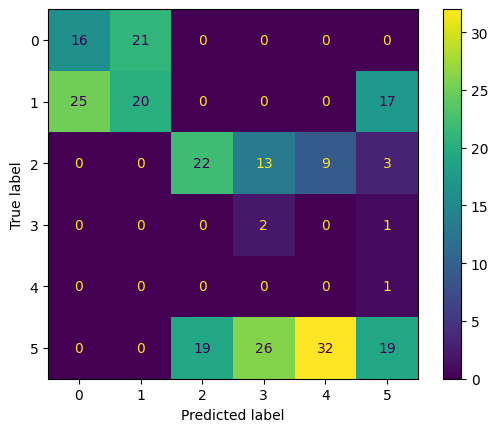

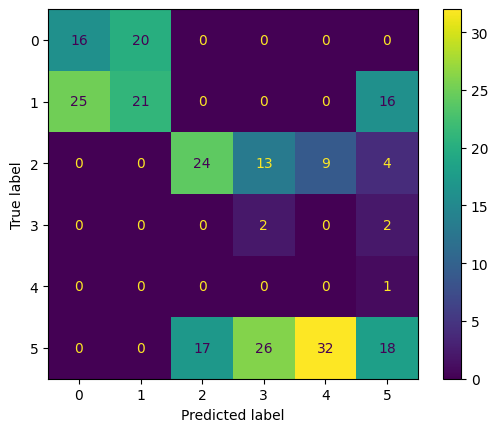

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


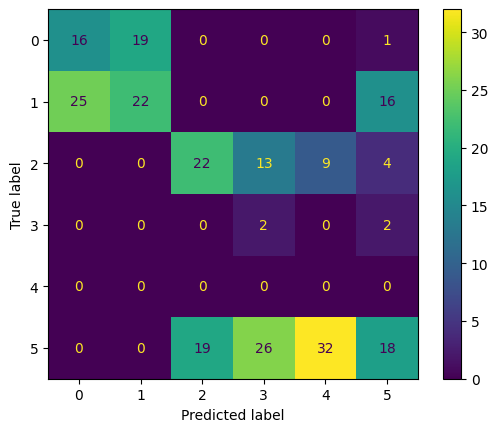

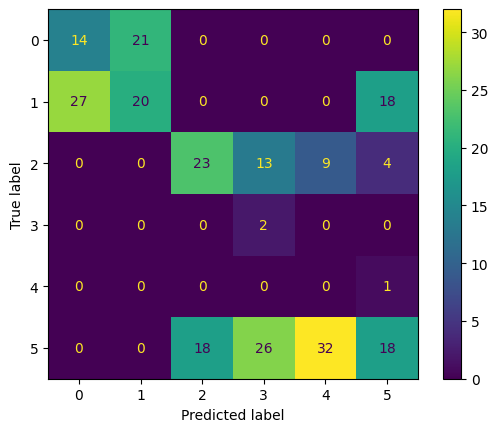

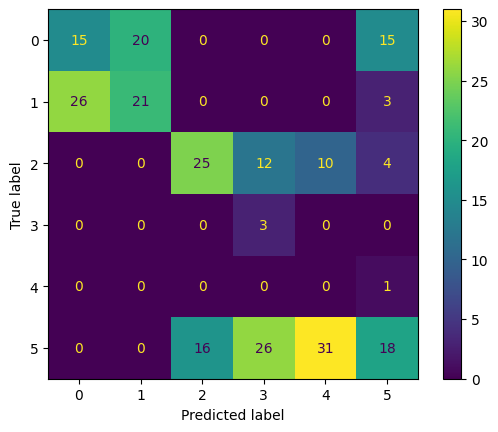

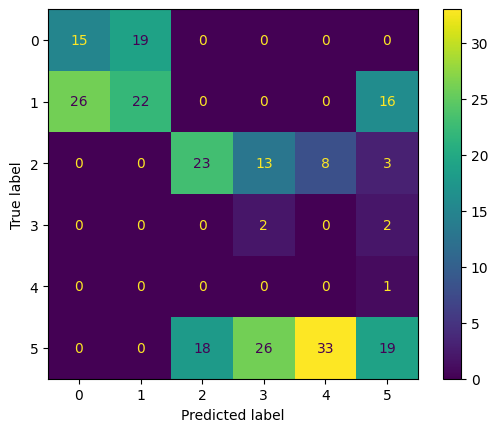

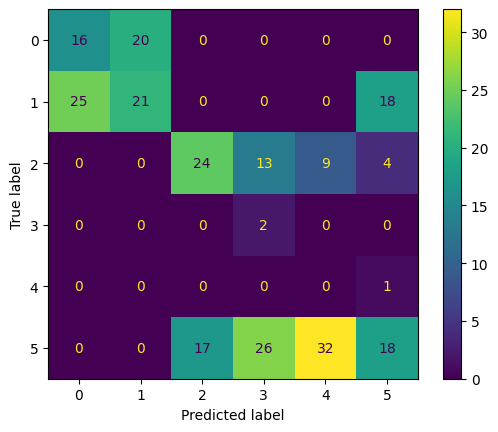

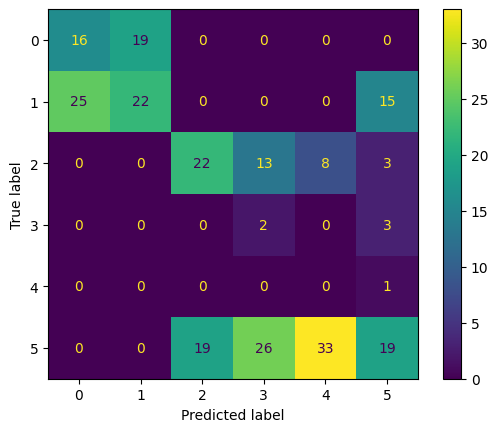

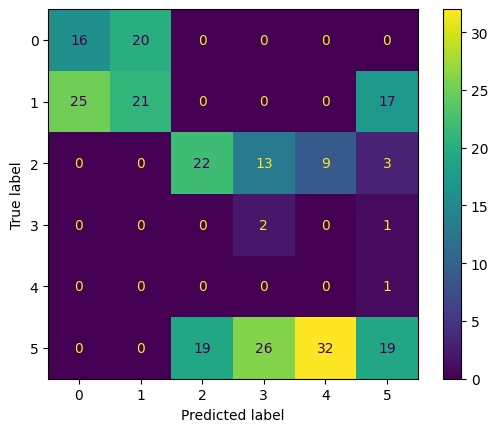

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


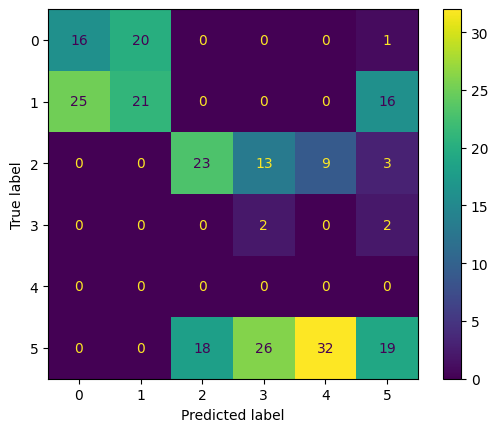

Mean accuracy (10 runs): 0.3264. Mean f1-score: 0.3705.Std accuracy (10 runs): 0.0055. Std f1-score: 0.0057


In [42]:
experiment = SimpleTrainEvalWorkflow(
    estimator=RandomForestClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=10, debug=False)
results = multi_run_experiment(train_reduced, [test_reduced])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)

print(f"Mean accuracy (10 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}.Std accuracy (10 runs): {std_acc:.4f}. Std f1-score: {std_f1:.4f}")

### SVM

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


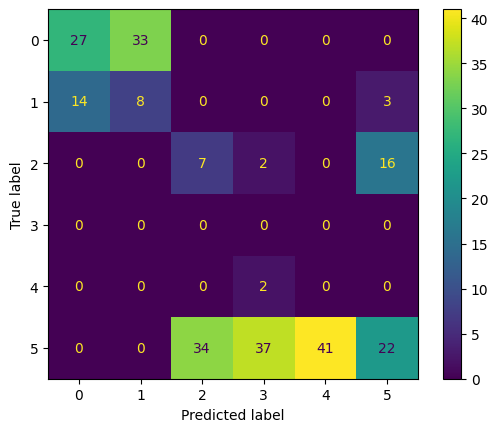

Mean accuracy (1 runs): 0.2602. Mean f1-score: 0.3136.Std accuracy (1 runs): 0.0000. Std f1-score: 0.0000


In [43]:
experiment = SimpleTrainEvalWorkflow(
    estimator=SVC,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
results = multi_run_experiment(train_reduced, [test_reduced])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)

print(f"Mean accuracy (1 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}.Std accuracy (1 runs): {std_acc:.4f}. Std f1-score: {std_f1:.4f}")

### KNN

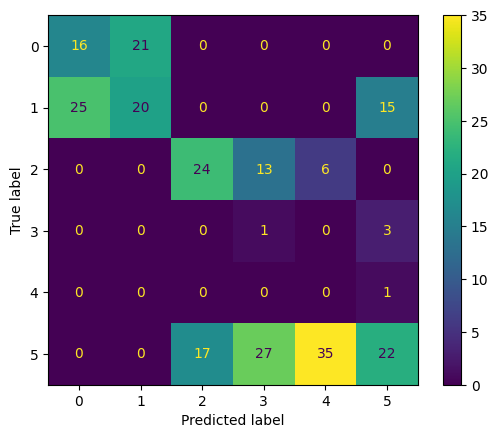

Mean accuracy (1 runs): 0.3374. Mean f1-score: 0.3861.Std accuracy (1 runs): 0.0000. Std f1-score: 0.0000


In [44]:
experiment = SimpleTrainEvalWorkflow(
    estimator=KNeighborsClassifier,
    do_not_instantiate=False,
    do_fit=True,
    evaluator=reporter,
)

multi_run_experiment = MultiRunWorkflow(workflow=experiment, num_runs=1, debug=False)
results = multi_run_experiment(train_reduced, [test_reduced])

mean_acc = np.average(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

std_acc = np.std(
    [res["result"][0]["accuracy"] for res in results["runs"]]
)

mean_f1 = np.average(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)
std_f1 = np.std(
    [res["result"][0]["f1 score (weighted)"] for res in results["runs"]]
)

print(f"Mean accuracy (1 runs): {mean_acc:.4f}. Mean f1-score: {mean_f1:.4f}.Std accuracy (1 runs): {std_acc:.4f}. Std f1-score: {std_f1:.4f}")